In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


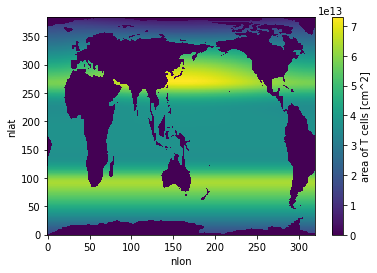

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.32:45440 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
def monthly_clim(ds):
    vars_time_dep = [v for v in ds.variables if 'time' in ds[v].dims]
    vars_other = list(set(ds.variables) - set(vars_time_dep))   
    
    encoding = {v: ds[v].encoding for v in vars_time_dep}
    dso =  ds[vars_time_dep].groupby('time.month').mean('time').rename({'month': 'time'})
    for v in vars_time_dep:
        dso[v].encoding = encoding[v]
    return xr.merge([dso, ds[vars_other]])

In [6]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400. * 365.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'FG_CO2',
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'co2-flux-{variable}', trust_cache=True,)
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        postprocess=monthly_clim,
        mean_dims=['member_id'],
    ))
    
ds = xr.merge(ds_list)

#ds['TAREA'] = grid.TAREA

convert_glb = dict(
    FG_CO2=(-1.0) * 1e-9 * 86400. * 365. * 12e-15,
)

ds_glb = xr.Dataset()
for v in convert_glb.keys():
    ds_glb[v] = (masked_area * ds[v].mean('time')).sum(['nlat', 'nlon']) * convert_glb[v]
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
    
from netCDF4 import default_fillvals    
ds.FG_CO2.data = ds.FG_CO2 * nmolcm2s_to_molm2yr * (-1.0) # reverse sign
ds.FG_CO2.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'
ds.FG_CO2.encoding['coordinates'] = 'TLONG TLAT time'
ds.FG_CO2.encoding['_FillValue'] = default_fillvals['f4']
ds['time'] = ds.time.astype(np.int32)
ds

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/co2-flux-FG_CO2.nc


<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, time: 12, z_t: 60)
Coordinates:
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    ULAT         (nlat, nlon) float64 ...
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    FG_CO2       (time, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    TAREA        (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    KMT          (nlat, nlon) float64 ...
    REGION_MASK  (nlat, nlon) float64 ...

In [7]:
ds_glb

<xarray.Dataset>
Dimensions:  (region: 1)
Dimensions without coordinates: region
Data variables:
    FG_CO2   (region) float64 -2.039

In [8]:
del client
del cluster

In [9]:
with xr.open_dataset('/glade/p/cgd/oce/projects/cesm2-marbl/fgco2-MPI-SOM-FFN_POP_gx1v7.nc') as ds_obs:
    with xr.set_options(keep_attrs=True):
        ds_obs = monthly_clim(ds_obs.sel(time=slice('1990', '2014'))).load()

ds_obs_glb = (masked_area * ds_obs['fgco2_smoothed'].mean('time')).sum(['nlat', 'nlon']) * 12e-15 * 1e-4

import intake
cat = intake.open_catalog('catalogs/fgco2_MPI-SOM-FFN.yml')
with xr.set_options(keep_attrs=True):
    ds_tmp = monthly_clim(cat.fgco2_MPI_SOM_FFN().to_dask()[['fgco2_smoothed']].sel(time=slice('1990', '2014'))).compute()
    ds_obs_za = ds_tmp.mean('lon')

#for v in ['fgco2_smoothed', 'fgco2_raw']:
#     ds_obs[v].encoding['_FillValue'] = -1e36
         
#ds_obs['time'] = ds_obs.time.astype(np.int32)

In [10]:
ds_obs_glb

<xarray.DataArray (region: 1)>
array([-1.4174079])
Dimensions without coordinates: region

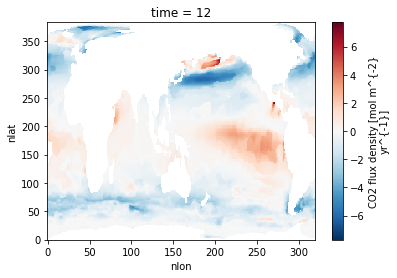

In [11]:
ds_obs.fgco2_raw.isel(time=-1).plot() #('time').plot()

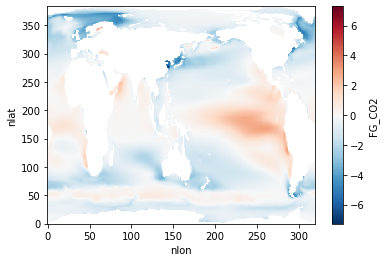

In [12]:
ds.FG_CO2.mean('time').plot()

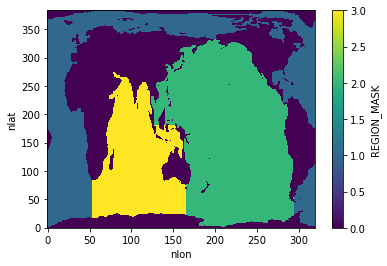

In [13]:
mask2d = utils.get_pop_region_mask_za(mask_type='2D')
mask2d.plot()

In [14]:
#
ds_za = utils.zonal_mean_via_fortran(ds, grid='POP_gx1v7', region_mask=mask2d,)
ds_za

za ran successfully, writing netcdf output


<xarray.Dataset>
Dimensions:      (basins: 4, lat_t: 394, lat_t_edges: 395, time: 12)
Coordinates:
  * lat_t        (lat_t) float32 -79.22 -78.69 -78.15 ... 88.84 89.37 89.9
  * lat_t_edges  (lat_t_edges) float32 -79.49 -78.95 -78.42 ... 89.1 89.64 90.0
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: basins
Data variables:
    FG_CO2       (basins, time, lat_t) float32 ...

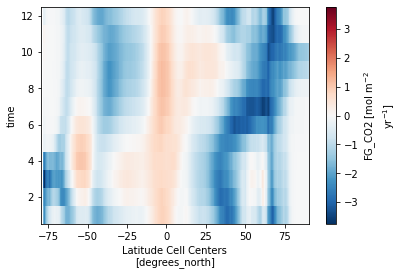

In [15]:
ds_za.FG_CO2.isel(basins=0).plot()

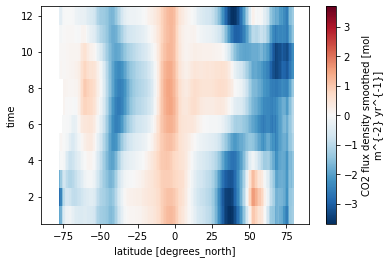

In [16]:
ds_obs_za.fgco2_smoothed.plot()

In [17]:
dsa = ds.mean('time').rename({'FG_CO2': 'fgco2'})
dsa['fgco2_obs'] = ds_obs.fgco2_smoothed.mean('time')
dsa = utils.pop_add_cyclic(dsa)
dsa

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 321, z_t: 60)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG        (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 -39.86
    fgco2        (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    TAREA        (nlat, nlon) float64 8.592e+12 8.592e+12 ... 3.341e+12
    dz           (z_t) float32 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    KMT          (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    REGION_MASK  (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fgco2_obs    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


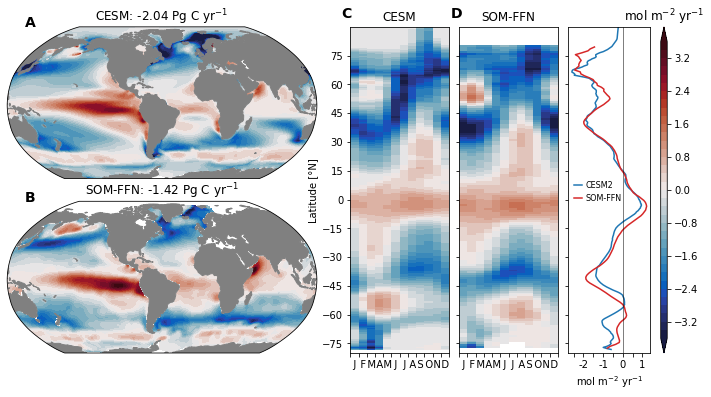

In [73]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

gs = gridspec.GridSpec(
    nrows=2, ncols=6, 
    width_ratios=(1, 0.01, 0.3, 0.3, 0.25, 0.02),
    wspace=0.1, 
    hspace=0.15,
)

axs = np.empty((nrow, ncol)).astype(object)

axs_map = [
    plt.subplot(gs[0, 0], projection=prj),
    plt.subplot(gs[1, 0], projection=prj),
]
cax = plt.subplot(gs[:, -1])

axs_za = [
    plt.subplot(gs[:, 2]),
    plt.subplot(gs[:, 3]),
]

ax_za_mean = plt.subplot(gs[:, 4])

cmap = cmocean.cm.balance

levels = np.arange(-3.6, 3.8, 0.2)

for field, ax in zip(['fgco2', 'fgco2_obs'], axs_map):
       
    cf = ax.contourf(
        dsa.TLONG, dsa.TLAT, dsa[field],
        levels=levels,
        extend='both',
        cmap=cmap, 
        norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
        transform=ccrs.PlateCarree(),
    )
    
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )      
    
    
axs_map[0].set_title(f'CESM: {ds_glb.FG_CO2.values[0]:0.2f} Pg C yr$^{{-1}}$')
axs_map[1].set_title(f'SOM-FFN: {ds_obs_glb.values[0]:0.2f} Pg C yr$^{{-1}}$')

axs_za[0].pcolormesh(
    np.arange(0, 13, 1), 
    ds_za.lat_t_edges, 
    ds_za.FG_CO2.isel(basins=0).T, 
    cmap=cmap, 
    norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
)

axs_za[1].pcolormesh(
    np.arange(0, 13, 1), 
    ds_obs_za.lat,
    ds_obs_za.fgco2_smoothed.T,
    cmap=cmap, 
    norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
)

ax_za_mean.plot(ds_za.FG_CO2.isel(basins=0).mean('time'), ds_za.lat_t, '-', color='tab:blue', label='CESM2')
ax_za_mean.plot(ds_obs_za.fgco2_smoothed.mean('time'), ds_obs_za.lat, '-', color='tab:red', label='SOM-FFN')

monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

for ax in axs_za:
    ax.set_ylim([-80, 90.])
    ax.set_yticks(np.arange(-75, 90, 15))
    ax.set_xticks(np.arange(0, 13))
    ax.set_xticklabels([f'   {m}' for m in monlabs]+['']);
axs_za[0].set_ylabel('Latitude [°N]')
axs_za[1].set_yticklabels([])

axs_za[0].set_title('CESM')
axs_za[1].set_title('SOM-FFN')

ax_za_mean.set_ylim([-80, 90.])
ax_za_mean.set_yticks(np.arange(-75, 90, 15))
ax_za_mean.set_yticklabels([])
ax_za_mean.set_xticks(np.arange(-2.5, 1.5, 0.5))
ax_za_mean.set_xticklabels(['', '-2', '', -1, '', '0', '', '1'])
ax_za_mean.axvline(0., linewidth=0.5, color='k',)
ax_za_mean.set_xlabel('mol m$^{-2}$ yr$^{-1}$')

ax_za_mean.legend(loc=(0.03, 0.45), frameon=False, handlelength=1.0, fontsize=8, handletextpad=0.5)

utils.label_plots(fig, [ax for ax in axs_map], xoff=0.02, yoff=0)       
utils.label_plots(fig, [ax for ax in axs_za], xoff=-0.01, start=2)

plt.colorbar(cf, cax=cax)
cax.set_title('mol m$^{-2}$ yr$^{-1}$')

utils.savefig('fgco2.pdf')

Text(0.5, 1.0, 'mol m$^{-2}$ yr$^{-1}$')

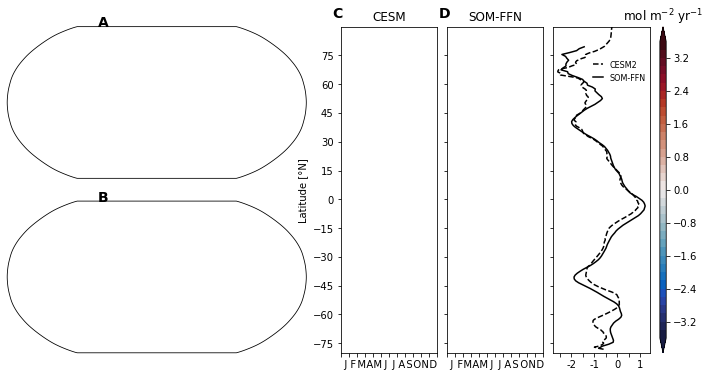

In [65]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

gs = gridspec.GridSpec(
    nrows=2, ncols=6, 
    width_ratios=(1, 0.01, 0.3, 0.3, 0.3, 0.02),
    wspace=0.1, 
    hspace=0.15,
)

axs = np.empty((nrow, ncol)).astype(object)

axs_map = [
    plt.subplot(gs[0, 0], projection=prj),
    plt.subplot(gs[1, 0], projection=prj),
]
cax = plt.subplot(gs[:, -1])

axs_za = [
    plt.subplot(gs[:, 2]),
    plt.subplot(gs[:, 3]),
]

ax_za_mean = plt.subplot(gs[:, 4])


ax_za_mean.plot(ds_za.FG_CO2.isel(basins=0).mean('time'), ds_za.lat_t, '--', color='k', label='CESM2')
ax_za_mean.plot(ds_obs_za.fgco2_smoothed.mean('time'), ds_obs_za.lat, '-', color='k', label='SOM-FFN')

monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

for ax in axs_za:
    ax.set_ylim([-80, 90.])
    ax.set_yticks(np.arange(-75, 90, 15))
    ax.set_xticks(np.arange(0, 13))
    ax.set_xticklabels([f'   {m}' for m in monlabs]+['']);
axs_za[0].set_ylabel('Latitude [°N]')
axs_za[1].set_yticklabels([])

axs_za[0].set_title('CESM')
axs_za[1].set_title('SOM-FFN')

ax_za_mean.set_ylim([-80, 90.])
ax_za_mean.set_yticks(np.arange(-75, 90, 15))
ax_za_mean.set_yticklabels([])
ax_za_mean.set_xticks(np.arange(-2.5, 1.5, 0.5))
ax_za_mean.set_xticklabels(['', '-2', '', -1, '', '0', '', '1'])



utils.label_plots(fig, [ax for ax in axs_map], xoff=0.02, yoff=0)       
utils.label_plots(fig, [ax for ax in axs_za], xoff=-0.01, start=2)

plt.colorbar(cf, cax=cax)
cax.set_title('mol m$^{-2}$ yr$^{-1}$')